In [52]:
import pandas as pd
import numpy as np

import datetime as dt
import math

import statsmodels.stats.power as smp
import scipy.stats as sts

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('hw4.csv', sep=';', index_col=0)
data.head()

,purchaseSystem,orderRevenue,experimentVariant
1,Pp,"15,99",Treatment
2,Pp,"17,99",Treatment
3,Pp,"15,99",Treatment
4,Pp,"15,99",Treatment
5,Pp,"17,99",Treatment


In [37]:
data.orderRevenue = data.orderRevenue.str.replace(",",".").astype('float')

In [45]:
data.groupby('experimentVariant').orderRevenue.agg(['sum','mean','std','count'])

,sum,mean,std,count
experimentVariant,,,,
Control,14432.54,17.059740,3.085159,846
Treatment,13459.07,16.972346,3.400415,793


In [44]:
data.groupby(['experimentVariant','purchaseSystem']).orderRevenue.agg(['sum','mean','std','count'])

sum       mean       std  count
experimentVariant purchaseSystem                                     
Control           Pp              9513.05  15.988319  2.099783    595
                  St              2532.79  20.932149  2.507647    121
                  Yc              2386.70  18.359231  3.890235    130
Treatment         Pp              8787.54  16.094396  2.002315    546
                  St              3123.57  21.843147  2.328507    143
                  Yc              1547.96  14.884231  4.335266    104

## Задача 1
Есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста

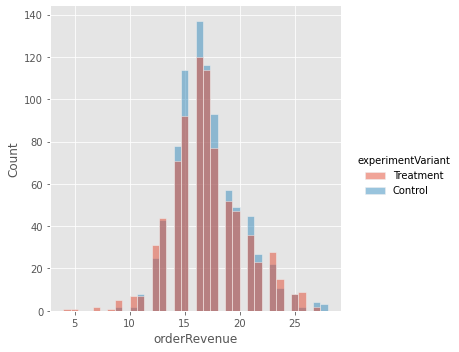

In [48]:
sns.displot(
    data=data,
    x='orderRevenue',
    hue='experimentVariant'
);

In [58]:
test_data = data[data['experimentVariant'] == 'Treatment'].orderRevenue
control_data = data[data['experimentVariant'] == 'Control'].orderRevenue

t, p_value = sts.ttest_ind(
    test_data,
    control_data,
    equal_var=False
)
print(t, p_value)

-0.5437574209912184 0.5866843840582027


### Вывод
P-Value значительно выше 0.05, поэтому нет оснований отвергнуть нулевую гипотезу - стат. значимой разницы между группами не выявлено.

## Задача 2
Есть ли значимое изменение в большую или меньшую сторону у суммы списаний в зависимости от варианта теста и платежной системы

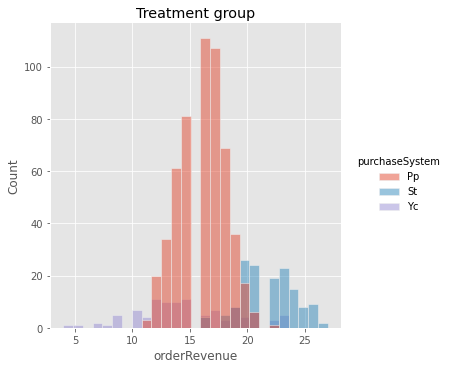

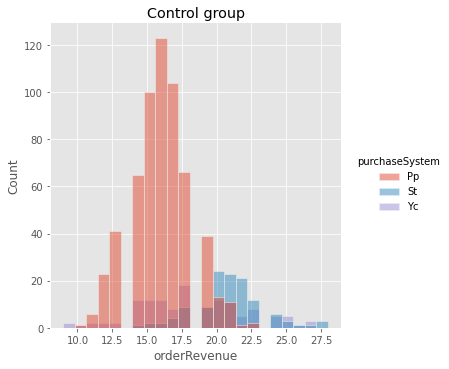

In [63]:
sns.displot(
    data=data[data['experimentVariant'] == 'Treatment'],
    x='orderRevenue',
    hue='purchaseSystem'
).set(title='Treatment group')
sns.displot(
    data=data[data['experimentVariant'] == 'Control'],
    x='orderRevenue',
    hue='purchaseSystem'
).set(title='Control group');

In [70]:
purchaseSystem_list = list(set(data.purchaseSystem))

In [78]:
t_list = []
p_value_list = []

for ps in purchaseSystem_list:
    test = data[(data['experimentVariant'] == 'Treatment')&(data['purchaseSystem'] == ps)].orderRevenue
    control = data[(data['experimentVariant'] == 'Control')&(data['purchaseSystem'] == ps)].orderRevenue
    
    t, p_value = sts.ttest_ind(
        test,
        control,
        equal_var=False
    )
    
    t_list.append(t)
    p_value_list.append(p_value)

In [80]:
result = pd.DataFrame({
    'purchaseSystem': purchaseSystem_list,
    't': t_list,
    'p_value': p_value_list
})

result

,purchaseSystem,t,p_value
0,Yc,-6.375004,1.150395e-09
1,Pp,0.873323,3.826713e-01
2,St,3.038601,2.631440e-03


In [119]:
bonferonni = .05 / 3
result['bonferonni'] = bonferonni

result['reject Ho'] = result.apply(lambda x: x.p_value < x.bonferonni, axis=1)
result

,purchaseSystem,t,p_value,bonferonni,reject Ho
0,Yc,-6.375004,1.150395e-09,0.016667,True
1,Pp,0.873323,3.826713e-01,0.016667,False
2,St,3.038601,2.631440e-03,0.016667,True


### Вывод
- Для проверки гипотезы с использованием множественных сравнений была использована поправка Бонферонни
- Для платежных систем Yc и St у нас есть все основания отвергнуть нелувую гипотезу, поскольку p value получился не только ниже 0.05, но и ниже уровня поправки Бонферонни
- При этом платежная система Pp не показала никаких стат. значимых изменений. Что довольно логично, поскольку изменения ее не коснулись.

- Учитывая что:
    - результаты тестовой и контрольной групп одинаковые (по результатам первой проверки)
    - Pp не изменилась
    - Yc изменилась и в тестовой группе средний объем платежей вырос (с 20.9 в контроле до 21.8 в тесте)
    - St изменилась и в тестовой группе средний объем платежей снизился (с 18 в контроле до 14.9 в тесте)
    
> Могла произойти каннибализация и платежи из St перетекли в Yc